# Notebook Hakkında
* Hazırlayan : Ikra Nergiz
* e-mail : ikranergiz0@gmail.com
* GitHub : [ikranergiz](https://github.com/ikranergiz)

# Google Drive'a Bağlanma

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# YOLO-NAS Kurulumu

Kurulumun ardından **Restart Runtime** ile Notebook'u yeniden başlatmayı unutmayın!

In [ ]:
!pip install super-gradients==3.3.1

# Kütüphaneleri Ekleme

In [ ]:
from IPython.display import clear_output
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

# Konfigürasyon

In [ ]:
class config:
    #eğitim parametreleri
    CHECKPOINT_DIR = '/content/drive/MyDrive/Bitirme Tezi/Veri seti/checkpoints'# checkpoint klasörünün tam yolu (absolute path)
    EXPERIMENT_NAME = 'yolonas_calismam' # eğitim sürecine verdiğimiz isim

    #veri seti parametreleri
    DATA_DIR = '/content/drive/MyDrive/Bitirme Tezi/Veri seti/supernova-dataset-v8' # veri setinin bulunduğu ana klasör

    TRAIN_IMAGES_DIR = 'train/images' # DATA_DIR içinde eğitim verilerinin bulunduğu klasörün yolu
    TRAIN_LABELS_DIR = 'train/labels' # DATA_DIR içinde eğitim verilerinin etiketlerinin bulunduğu klasörün yolu

    VAL_IMAGES_DIR = 'val/images' # DATA_DIR içinde validasyon verilerinin bulunduğu klasörün yolu
    VAL_LABELS_DIR = 'val/labels' # DATA_DIR içinde validasyon verilerinin etiketlerinin  bulunduğu klasörün yolu

    TEST_IMAGES_DIR = 'test/images' # DATA_DIR içinde test verilerinin bulunduğu klasörün yolu
    TEST_LABELS_DIR = 'test/labels' # DATA_DIR içinde test verilerinin etiketlerinin  bulunduğu klasörün yolu
    CLASSES = ['supernova'] # sınıfların isimleri.

    NUM_CLASSES = len(CLASSES)

    #ver-yükleyici (dataloader) parametreleri
    DATALOADER_PARAMS={
      'batch_size':16,
      'num_workers':2
    }

    # model parametreleri
    MODEL_NAME = 'yolo_nas_s' # yolo_nas_s, yolo_nas_m, yolo_nas_l arasından birini seçiyoruz
    PRETRAINED_WEIGHTS = 'coco' # burada tek seçenek var: 'coco'

# Trainer

In [ ]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# Veri Seti ve Dataloader

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2023-11-03 17:57:20] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 2100/2100 [07:16<00:00,  4.81it/s]
[2023-11-03 18:04:39] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 300/300 [00:59<00:00,  5.08it/s]
[2023-11-03 18:05:42] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|█████████▉| 599/600 [02:03<00:00,  7.73it/s]

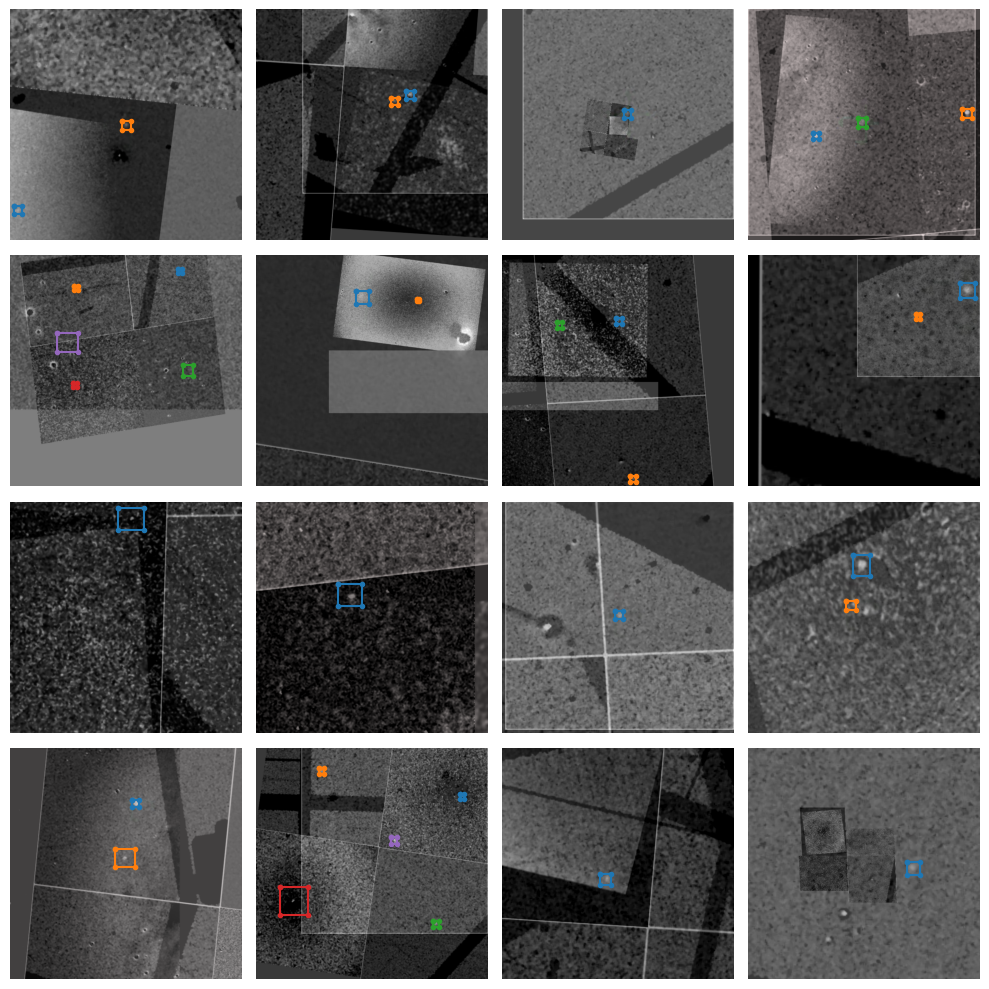

In [ ]:
train_data.dataset.plot()

# Modeli Oluşturma

In [ ]:
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2023-11-03 18:07:58] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:01<00:00, 55.6MB/s]
[2023-11-03 18:08:00] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


Eğitim Parametreleri ve Metrikleri Ayarlama

In [ ]:
train_params = {
    "average_best_models":True,
    "warmup_mode": "LinearEpochLRWarmup",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # BU ÖRNEK İÇİN 10 EPOCH EĞİTECEĞİZ
    "max_epochs": 5,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOT: num_classes burada tanımlanması gerekiyor
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOT: num_classes burada tanımlanması gerekiyor
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# Modeli Eğitme

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-11-03 18:08:14] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231103_180814_409425`
[2023-11-03 18:08:14] INFO - sg_trainer.py - Checkpoints directory: /content/drive/MyDrive/Bitirme Tezi/Veri seti/checkpoints/yolonas_calismam/RUN_20231103_180814_409425
[2023-11-03 18:08:14] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /content/drive/MyDrive/Bitirme Tezi/Veri seti/checkpoints/yolonas_calismam/RUN_20231103_180814_409425/console_Nov03_18_08_14.txt


[2023-11-03 18:08:18] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            2100       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         131        (len(train_loader))
    - Gradient updates per epoch:   131        (len(train_loader) / batch_accumulate)

[2023-11-03 18:08:18] INFO - sg_trainer.py - Started training for 5 epochs (0/4)

Validating: 100%|██████████| 18/18 [00:07<00:00,  2.30it/s]
[2023-11-03 18:11:31] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Bitirme Tezi/Veri seti/checkpoints/yolonas_calismam/RUN_20231103_1

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.8887
│   ├── Ppyoloeloss/loss_iou = 0.4994
│   ├── Ppyoloeloss/loss_dfl = 1.6038
│   └── Ppyoloeloss/loss = 3.9391
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.3763
    ├── Ppyoloeloss/loss_iou = 0.4651
    ├── Ppyoloeloss/loss_dfl = 1.3134
    ├── Ppyoloeloss/loss = 4.1959
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0
    └── F1@0.50 = 0.0



Validating epoch 1: 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]
[2023-11-03 18:14:57] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Bitirme Tezi/Veri seti/checkpoints/yolonas_calismam/RUN_20231103_180814_409425/ckpt_best.pth
[2023-11-03 18:14:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4646774232387543


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2427
│   │   ├── Epoch N-1      = 1.8887 (↘ -0.646)
│   │   └── Best until now = 1.8887 (↘ -0.646)
│   ├── Ppyoloeloss/loss_iou = 0.3156
│   │   ├── Epoch N-1      = 0.4994 (↘ -0.1839)
│   │   └── Best until now = 0.4994 (↘ -0.1839)
│   ├── Ppyoloeloss/loss_dfl = 0.974
│   │   ├── Epoch N-1      = 1.6038 (↘ -0.6298)
│   │   └── Best until now = 1.6038 (↘ -0.6298)
│   └── Ppyoloeloss/loss = 2.5186
│       ├── Epoch N-1      = 3.9391 (↘ -1.4205)
│       └── Best until now = 3.9391 (↘ -1.4205)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0746
    │   ├── Epoch N-1      = 2.3763 (↘ -1.3017)
    │   └── Best until now = 2.3763 (↘ -1.3017)
    ├── Ppyoloeloss/loss_iou = 0.2726
    │   ├── Epoch N-1      = 0.4651 (↘ -0.1925)
    │   └── Best until now = 0.4651 (↘ -0.1925)
    ├── Ppyoloeloss/loss_dfl = 0.7352
    │   ├── Epoch N-1      = 1.3134 (↘ -0.5782)
    │   └── Best until now = 1.3134 (↘ -0.5782)
    ├── Ppyoloeloss/loss 

Validating epoch 2: 100%|██████████| 18/18 [00:08<00:00,  2.24it/s]
[2023-11-03 18:18:18] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Bitirme Tezi/Veri seti/checkpoints/yolonas_calismam/RUN_20231103_180814_409425/ckpt_best.pth
[2023-11-03 18:18:18] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.624608039855957


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1693
│   │   ├── Epoch N-1      = 1.2427 (↘ -0.0734)
│   │   └── Best until now = 1.2427 (↘ -0.0734)
│   ├── Ppyoloeloss/loss_iou = 0.272
│   │   ├── Epoch N-1      = 0.3156 (↘ -0.0436)
│   │   └── Best until now = 0.3156 (↘ -0.0436)
│   ├── Ppyoloeloss/loss_dfl = 0.8643
│   │   ├── Epoch N-1      = 0.974  (↘ -0.1098)
│   │   └── Best until now = 0.974  (↘ -0.1098)
│   └── Ppyoloeloss/loss = 2.2814
│       ├── Epoch N-1      = 2.5186 (↘ -0.2372)
│       └── Best until now = 2.5186 (↘ -0.2372)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.026
    │   ├── Epoch N-1      = 1.0746 (↘ -0.0486)
    │   └── Best until now = 1.0746 (↘ -0.0486)
    ├── Ppyoloeloss/loss_iou = 0.2464
    │   ├── Epoch N-1      = 0.2726 (↘ -0.0262)
    │   └── Best until now = 0.2726 (↘ -0.0262)
    ├── Ppyoloeloss/loss_dfl = 0.7008
    │   ├── Epoch N-1      = 0.7352 (↘ -0.0344)
    │   └── Best until now = 0.7352 (↘ -0.0344)
    ├── Ppyoloeloss/loss

Validating epoch 3: 100%|██████████| 18/18 [00:07<00:00,  2.39it/s]
[2023-11-03 18:21:57] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Bitirme Tezi/Veri seti/checkpoints/yolonas_calismam/RUN_20231103_180814_409425/ckpt_best.pth
[2023-11-03 18:21:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7128276824951172


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.101
│   │   ├── Epoch N-1      = 1.1693 (↘ -0.0682)
│   │   └── Best until now = 1.1693 (↘ -0.0682)
│   ├── Ppyoloeloss/loss_iou = 0.2537
│   │   ├── Epoch N-1      = 0.272  (↘ -0.0183)
│   │   └── Best until now = 0.272  (↘ -0.0183)
│   ├── Ppyoloeloss/loss_dfl = 0.8467
│   │   ├── Epoch N-1      = 0.8643 (↘ -0.0175)
│   │   └── Best until now = 0.8643 (↘ -0.0175)
│   └── Ppyoloeloss/loss = 2.1587
│       ├── Epoch N-1      = 2.2814 (↘ -0.1228)
│       └── Best until now = 2.2814 (↘ -0.1228)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0484
    │   ├── Epoch N-1      = 1.026  (↗ 0.0224)
    │   └── Best until now = 1.026  (↗ 0.0224)
    ├── Ppyoloeloss/loss_iou = 0.1902
    │   ├── Epoch N-1      = 0.2464 (↘ -0.0563)
    │   └── Best until now = 0.2464 (↘ -0.0563)
    ├── Ppyoloeloss/loss_dfl = 0.6248
    │   ├── Epoch N-1      = 0.7008 (↘ -0.0761)
    │   └── Best until now = 0.7008 (↘ -0.0761)
    ├── Ppyoloeloss/loss 

Validating epoch 4: 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]
[2023-11-03 18:25:33] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Bitirme Tezi/Veri seti/checkpoints/yolonas_calismam/RUN_20231103_180814_409425/ckpt_best.pth
[2023-11-03 18:25:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7348512411117554


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9927
│   │   ├── Epoch N-1      = 1.101  (↘ -0.1084)
│   │   └── Best until now = 1.101  (↘ -0.1084)
│   ├── Ppyoloeloss/loss_iou = 0.2194
│   │   ├── Epoch N-1      = 0.2537 (↘ -0.0343)
│   │   └── Best until now = 0.2537 (↘ -0.0343)
│   ├── Ppyoloeloss/loss_dfl = 0.762
│   │   ├── Epoch N-1      = 0.8467 (↘ -0.0848)
│   │   └── Best until now = 0.8467 (↘ -0.0848)
│   └── Ppyoloeloss/loss = 1.9222
│       ├── Epoch N-1      = 2.1587 (↘ -0.2364)
│       └── Best until now = 2.1587 (↘ -0.2364)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9273
    │   ├── Epoch N-1      = 1.0484 (↘ -0.1211)
    │   └── Best until now = 1.026  (↘ -0.0987)
    ├── Ppyoloeloss/loss_iou = 0.1748
    │   ├── Epoch N-1      = 0.1902 (↘ -0.0154)
    │   └── Best until now = 0.1902 (↘ -0.0154)
    ├── Ppyoloeloss/loss_dfl = 0.6115
    │   ├── Epoch N-1      = 0.6248 (↘ -0.0132)
    │   └── Best until now = 0.6248 (↘ -0.0132)
    ├── Ppyoloeloss/los

[2023-11-03 18:25:38] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 5: 100%|██████████| 18/18 [00:08<00:00,  2.72it/s]

## En İyi Modeli Alma

In [ ]:
import os
checkpoint_path_best_model = os.path.join(trainer.checkpoints_dir_path, "ckpt_latest.pth")

En son ağırlıklarla çalışmak için aşağıdaki kodu kullanın.

In [ ]:
checkpoint_path_latest_model = os.path.join(trainer.checkpoints_dir_path, "ckpt_latest.pth")

En iyi ağırlıkları kullanarak best modeli oluşturalım

In [ ]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=checkpoint_path_best_model)

[2023-11-03 18:39:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/Bitirme Tezi/Veri seti/checkpoints/yolonas_calismam/RUN_20231103_180814_409425/ckpt_latest.pth EMA checkpoint.


# En İyi Modeli Test Etme

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,                                                                              nms_threshold=0.7)
                                                  ))

Testing:  97%|█████████▋| 36/37 [00:17<00:00,  2.69it/s]

{'PPYoloELoss/loss_cls': 0.9425495,
 'PPYoloELoss/loss_iou': 0.17417213,
 'PPYoloELoss/loss_dfl': 0.6365692,
 'PPYoloELoss/loss': 1.6962644,
 'Precision@0.50': 0.015398330055177212,
 'Recall@0.50': 0.9612141847610474,
 'mAP@0.50': 0.7297742962837219,
 'F1@0.50': 0.030311087146401405}

Testing: 100%|██████████| 37/37 [00:18<00:00,  2.02it/s]


# En İyi Modelle Tahmin Üretme

Önemli! Eğer conf parametresini vermezseniz predict sonucu hiçbir bounding box (sınırlayıcı kutu) göremezsiniz.

[2023-11-03 18:46:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


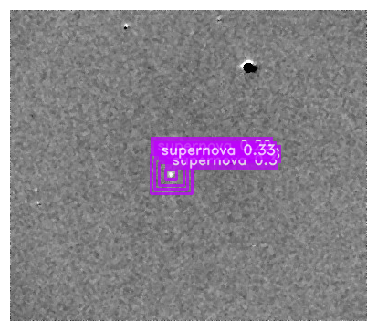

In [ ]:
best_model.predict( "/content/drive/MyDrive/h0005_2.jpg",  conf=0.25).show()

/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/media/image.py:64: UserWarning: It seems you are using predict() with batch input
  warnings.warn("It seems you are using predict() with batch input")
Predicting Images: 100%|██████████| 9/9 [00:00<00:00, 11.36it/s]


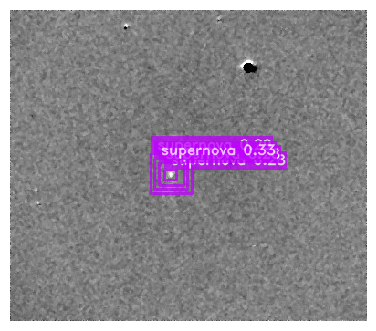

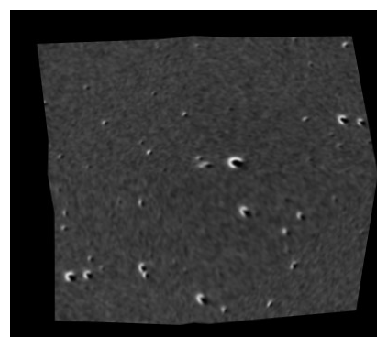

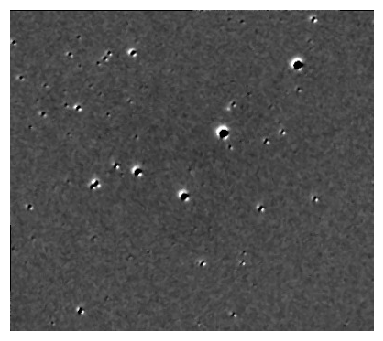

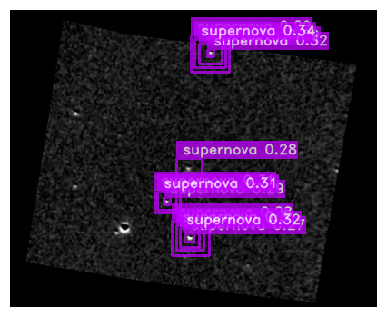

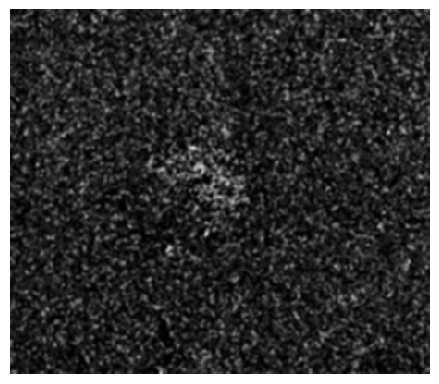

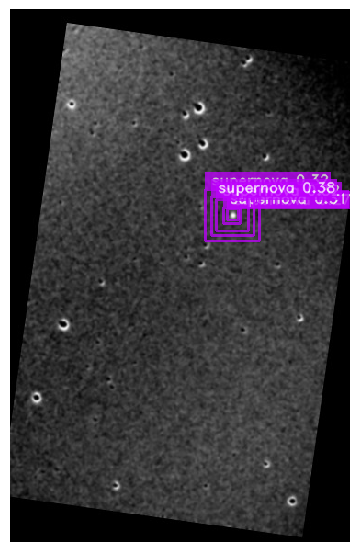

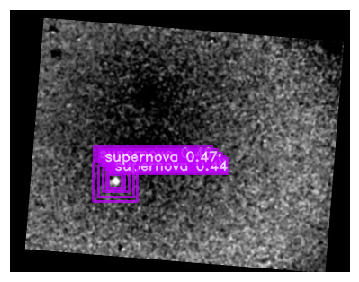

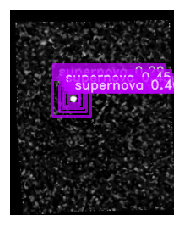

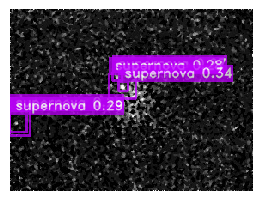

In [ ]:
IMAGES = [
    "/content/drive/MyDrive/h0005_2.jpg",
    "/content/drive/MyDrive/h0007_10.jpg",
    "/content/drive/MyDrive/h0009_16.jpg",
    "/content/drive/MyDrive/h0011_6.jpg",
    "/content/drive/MyDrive/h0020_14.jpg",
    "/content/drive/MyDrive/h0022_8.jpg",
    "/content/drive/MyDrive/h0024_11.jpg",
    "/content/drive/MyDrive/h0025_11.jpg",
    "/content/drive/MyDrive/h0027_9.jpg",
]

predictions = model.predict(IMAGES, conf=0.25)
predictions.show()